# Simulando una economía de mercado

<div class="alert alert-warning">
    
**Nota** _Basado en el libro_ Exploring everyday things with Ruby and R.
</div>

Exploraremos las ideas de **Adam Smith** y de la _mano invisible_ , para eso simularemos un mercado idealizado.

La simulación contendrá lo siguiente:

- _Productores_

- _Consumidores_

- _Precio_

- _Demanda_

- _Oferta_

- _Mercado_

En esta economía simplificada, los _productores_ crean bienes y los venden a los consumidores por el precio **que ellos establecen**.

Por su parte, los _consumidores_ compraran del productor, si el precio les parece razonable y sólo compraran si tienen una demanda que satisfacer. Los _consumidores_ pueden comprar de cualquier _productor_ , pero comprarán del que venda más barato.

In [5]:

import numpy as np
import matplotlib.pyplot as plt

In [6]:
class Productor:
    
    def __init__(self, id, oferta=0.0, precio=0.0):
        self.id = id
        self.oferta = oferta
        self.precio = precio
        
    def __repr__(self):
        return "<Productor %d> oferta: %d, precio: %d" % (self.id, self.oferta, self.precio)
    
    def __lt__(self, otro):
        return self.precio < otro.precio
    
    def __gt__(self, otro):
        return self.precio > otro.precio
    
    def existe_oferta(self):
        return self.oferta > 0
    
    def generar_bienes(self):
        if self.precio > COSTO:
            self.oferta = self.oferta + INCREMENTO_OFERTA
        
    def producir(self):
        if self.oferta > 0:
            if not self.precio < COSTO:
                self.precio = self.precio * DECREMENTO_PRECIO 
        else:
            self.precio = self.precio * INCREMENTO_PRECIO
            self.generar_bienes()
    

In [7]:
class Consumidor:
    
    def __init__(self, id, demandas = 0.0):
        self.id = id
        self.demandas = demandas
        
    def __repr__(self):
        return "<Consumidor %d> demandas: %d" % (self.id, self.demandas)
    
    def existe_necesidad(self):
        return self.demandas > 0
    
    def comprar(self, mercado):
        while self.existe_necesidad() and mercado.existe_oferta(): # Comprará mientras necesite satisfacer su demanda y haya oferta
            productor_mas_barato = mercado.productor_mas_barato()
            if productor_mas_barato: # Si hay un productor barato
                if productor_mas_barato.precio > PRECIO_MAXIMO_ACEPTABLE: # Si el precio es mayor que el aceptable
                    self.demandas = self.demandas * 0.5                   # reduzco mi demanda a la mitad

                oferta_mas_barata = productor_mas_barato.oferta
                
                if self.demandas > oferta_mas_barata:    # Si mi demanda supera a la oferta del productor
                    self.demandas = self.demandas - oferta_mas_barata
                    productor_mas_barato.oferta = 0.0
                else:                                    # En este caso mi demanda es menor que la oferta del productor
                    productor_mas_barato.oferta = productor_mas_barato.oferta - self.demandas
                    self.demandas = 0.0


In [9]:
from functools import reduce
import math
import random
import numpy as np

class Mercado:
    
    def __init__(self, num_productores, num_consumidores, duracion):
        self.productores = []
        self.consumidores = []
        self.demanda_generada = []
        
        self.duracion = duracion
        
        self.demanda_oferta = np.zeros([self.duracion, 2])
        self.precio_demanda = np.zeros([self.duracion, 2])
        
        for p_id in range(num_productores):
            productor = Productor(id=p_id)
            productor.precio = COSTO + random.randint(0, GANANCIA_MAXIMA_INICIAL)
            productor.oferta = random.randint(1,OFERTA_MAXIMA_INICIAL)
            self.productores.append(productor)
            
        for c_id in range(num_consumidores):
            consumidor = Consumidor(id = c_id)
            self.consumidores.append(consumidor)
            
        for t in range(duracion):
            self.demanda_generada.append(round((math.sin(t)+2)*20))
    
    def precio_promedio(self):
        suma_precios = sum([productor.precio for productor in self.productores])
        return round(suma_precios/len(self.productores), 2)
        
    def oferta_total(self):
        return sum([productor.oferta for productor in self.productores])
        
    def demanda_total(self):
        return sum([consumidor.demandas for consumidor in self.consumidores])
        
    
    def existe_oferta(self):
        return self.oferta_total() > 0
    
    def existe_demanda(self):
        return self.demanda_total() > 0
        
    def productor_mas_barato(self):
        mas_barato = None
        productores = [ productor for productor in self.productores if productor.oferta > 0 ]
        if productores:
            mas_barato = min(productores) 
        return mas_barato
    
    def evolucionar(self, step):
        for consumidor in self.consumidores:
            consumidor.demandas = self.demanda_generada[step]    
            
        self.demanda_oferta[step] = [self.demanda_total(), self.oferta_total()]
            
        for productor in self.productores:
            productor.producir()
        
        self.precio_demanda[step] = [self.precio_promedio(), self.demanda_total()]
        
        while self.existe_demanda() and self.existe_oferta():
            for consumidor in self.consumidores:
                consumidor.comprar(mercado=self)
        

In [10]:
duracion = 150
num_productores = 10
num_consumidores = 10

OFERTA_MAXIMA_INICIAL = 20
INCREMENTO_OFERTA = 80

COSTO = 5
PRECIO_MAXIMO_ACEPTABLE = COSTO * 1
GANANCIA_MAXIMA_INICIAL = 5

INCREMENTO_PRECIO = 1.1
DECREMENTO_PRECIO = 0.9


In [11]:
mercado_ideal = Mercado(num_productores, num_consumidores, duracion)

In [12]:
mercado_ideal.productor_mas_barato()

<Productor 0> oferta: 7, precio: 5

In [13]:
for t in range(duracion):
    mercado_ideal.evolucionar(t)

tiempo_simulacion = np.linspace(0,1, duracion)

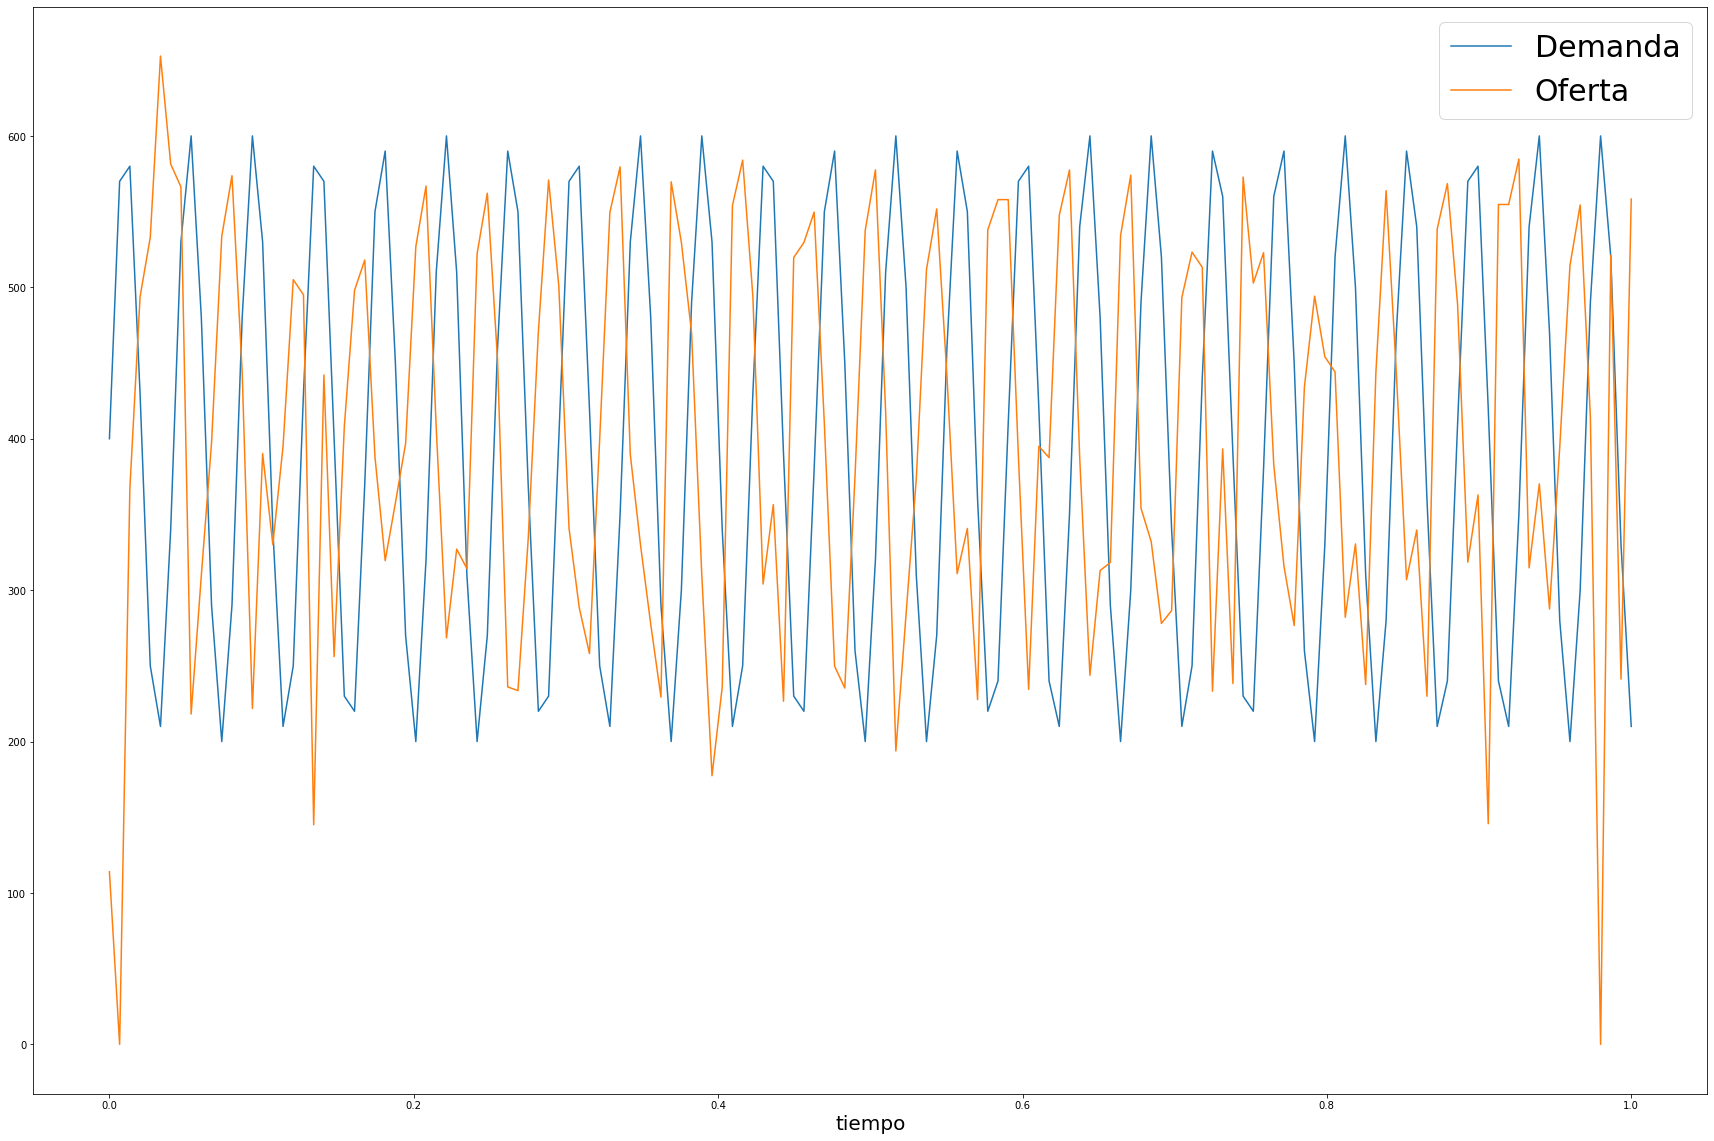

In [26]:
plt.figure(figsize = (30,20))
plt.plot(tiempo_simulacion, mercado_ideal.demanda_oferta[:,0], label="Demanda")
plt.plot(tiempo_simulacion, mercado_ideal.demanda_oferta[:,1], label="Oferta")
plt.xlabel("tiempo", size=20)
plt.legend(loc="best", fontsize=30)

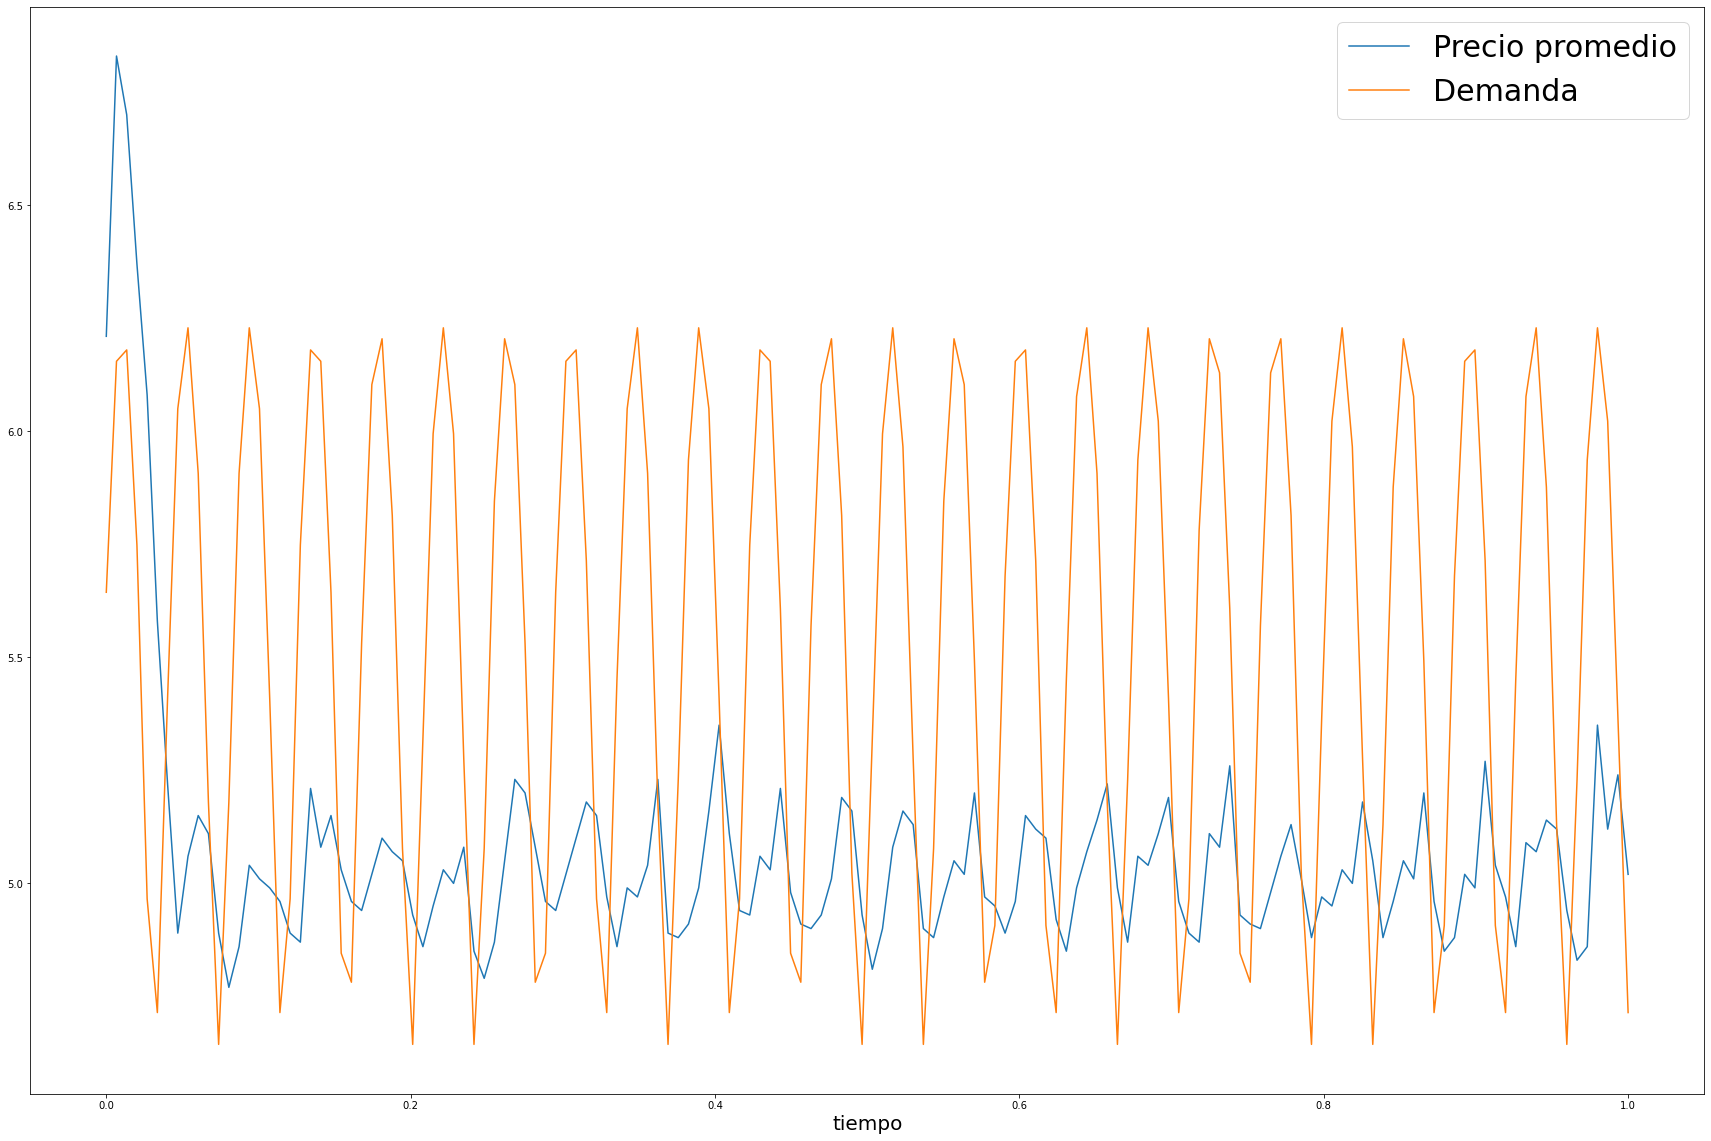

In [27]:
plt.figure(figsize = (30,20))
plt.plot(tiempo_simulacion, mercado_ideal.precio_demanda[:,0], '-', label="Precio promedio")
plt.plot(tiempo_simulacion, np.log2(mercado_ideal.precio_demanda[:,1]) - 3, label="Demanda")
plt.xlabel("tiempo", size=20)
plt.legend(loc="best", fontsize=30)

<div class=